In [104]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error,r2_score,roc_curve,auc,precision_recall_curve, accuracy_score, \
recall_score, precision_score, confusion_matrix
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import VotingRegressor, VotingClassifier, StackingRegressor, StackingClassifier, GradientBoostingRegressor,GradientBoostingClassifier, BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier,AdaBoostRegressor,AdaBoostClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
import itertools as it
import time as time
import xgboost as xgb
from pyearth import Earth
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings("ignore")
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import log_loss
from sklearn.feature_selection import RFE
from lightgbm import LGBMClassifier

In [65]:
# Import the data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
greeks = pd.read_csv('greeks.csv')

In [66]:
# Change to dummy variables
train['EJ'] = train['EJ'].apply(lambda x: 0 if x == 'A' else 1)
test['EJ'] = test['EJ'].apply(lambda x: 0 if x == 'A' else 1)

#Separating train data for predictors and response
X_train = train.drop('Class', axis = 1)
y_train = train.loc[:, 'Class']

#Dropping id column
X_train = X_train.drop('Id', axis = 1)
test = test.drop('Id', axis = 1)

#Creating validation data set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.10, stratify = y_train)

#Scaling the train and test data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(test)
X_val_scaled = scaler.transform(X_val)
X_train = pd.DataFrame(X_train_scaled)
X_test = pd.DataFrame(X_test_scaled)
X_val = pd.DataFrame(X_val_scaled)

In [78]:
#SKIP!!!
#Using for loop to iterate over potential values of n_neighbors for imputing missing values, using a 
#CatBoostRegressor() to get train MSE as the parameter to choose best value
scores = []
val_scores = []
for i in range(1, 40):
    imputer = KNNImputer(n_neighbors = i)
    X_train_imputed = imputer.fit_transform(X_train)
    model_test = CatBoostClassifier(verbose = False)
    model_test.fit(X_train_imputed, y_train)

    true_labels = np.array(y_train)
    predicted_probs = np.array(model_test.predict_proba(X_train_imputed))

    class_weights = np.mean(true_labels) / np.bincount(true_labels)
    logloss_per_class = log_loss(true_labels, predicted_probs, labels=[0, 1], normalize=False)
    balanced_logloss = np.sum(logloss_per_class * class_weights)
    scores.append(balanced_logloss)
    true_labels = np.array(y_val)
    predicted_probs = np.array(model_test.predict_proba(X_val))

    class_weights = np.mean(true_labels) / np.bincount(true_labels)
    logloss_per_class = log_loss(true_labels, predicted_probs, labels=[0, 1], normalize=False)
    balanced_logloss = np.sum(logloss_per_class * class_weights)
    
    val_scores.append(balanced_logloss)

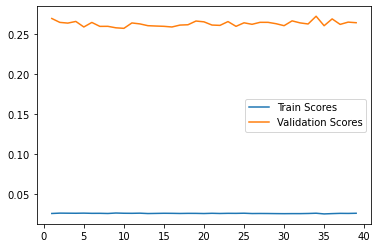

In [79]:
x = range(1, len(scores) + 1)
plt.plot(x, scores, label = 'Train Scores')
plt.plot(x, val_scores, label = 'Validation Scores')
plt.legend()

In [80]:
imputer = KNNImputer(n_neighbors = 10)
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)
X_train = pd.DataFrame(X_train_imputed)
X_val = pd.DataFrame(X_val_imputed)

In [67]:
# Initial data analysis
#print(train.isnull().sum())

In [75]:
y_train

292    0
450    0
148    0
559    1
522    0
      ..
58     0
178    0
610    0
233    0
216    0
Name: Class, Length: 555, dtype: int64

In [71]:
def balanced_log_loss(X_train, y_train, X_val, y_val, model_test):
    scores = []
    true_labels = np.array(y_train)
    predicted_probs = np.array(model_test.predict_proba(X_train))
    class_weights = np.mean(true_labels) / np.bincount(true_labels)
    logloss_per_class = log_loss(true_labels, predicted_probs, labels=[0, 1], normalize=False)
    balanced_logloss = np.sum(logloss_per_class * class_weights)
    scores.append(balanced_logloss)
    true_labels = np.array(y_val)
    predicted_probs = np.array(model_test.predict_proba(X_val))
    class_weights = np.mean(true_labels) / np.bincount(true_labels)
    logloss_per_class = log_loss(true_labels, predicted_probs, labels=[0, 1], normalize=False)
    balanced_logloss = np.sum(logloss_per_class * class_weights)
    scores.append(balanced_logloss)
    return scores

In [93]:
# With all performance
model = RandomForestClassifier()
model.fit(X_train, y_train)
results = balanced_log_loss(X_train, y_train, X_val, y_val, model)
print(f'The results are {results[0]} for train data and {results[1]} for validation data.')

The results are 0.08264023663397657 for train data and 0.9237965382605047 for validation data.


In [94]:
# With 50 variables performance
model = RandomForestClassifier()
rfe = RFE(model, n_features_to_select=50)
rfe.fit(X_train, y_train)
results = balanced_log_loss(X_train, y_train, X_val, y_val, rfe)
print(f'The results are {results[0]} for train data and {results[1]} for validation data.')

The results are 0.08294645924201895 for train data and 0.3432603163684188 for validation data.


In [95]:
# With 40 variables performance
model = RandomForestClassifier()
rfe = RFE(model, n_features_to_select=40)
rfe.fit(X_train, y_train)
results = balanced_log_loss(X_train, y_train, X_val, y_val, rfe)
print(f'The results are {results[0]} for train data and {results[1]} for validation data.')

The results are 0.08005792163385073 for train data and 0.32501721659281196 for validation data.


In [99]:
# With 30 variables performance
model = RandomForestClassifier()
rfe = RFE(model, n_features_to_select=30)
rfe.fit(X_train, y_train)
results = balanced_log_loss(X_train, y_train, X_val, y_val, rfe)
print(f'The results are {results[0]} for train data and {results[1]} for validation data.')

The results are 0.07577995942699271 for train data and 0.32218710570319986 for validation data.


In [97]:
# With 20 variables performance
model = RandomForestClassifier()
rfe = RFE(model, n_features_to_select=20)
rfe.fit(X_train, y_train)
results = balanced_log_loss(X_train, y_train, X_val, y_val, rfe)
print(f'The results are {results[0]} for train data and {results[1]} for validation data.')

The results are 0.07242304973221542 for train data and 0.9020813926608242 for validation data.


In [98]:
# With 10 variables performance
model = RandomForestClassifier()
rfe = RFE(model, n_features_to_select=10)
rfe.fit(X_train, y_train)
results = balanced_log_loss(X_train, y_train, X_val, y_val, rfe)
print(f'The results are {results[0]} for train data and {results[1]} for validation data.')

The results are 0.07508378540226826 for train data and 0.8997287742485649 for validation data.


In [102]:
start_time = time.time()
param_grid = {'max_depth': [4, 6, 8],
              'learning_rate': [0.01, 0.1, 0.2],
               'reg_lambda': [0.1, 1, 100],
                'n_estimators': [100, 500, 1000],
                'subsample': [0.5, 0.75, 1.0],
             'reg_lambda': [0, 10, 100],
             'colsample_bylevel': [0.5, 0.75, 1.0]}

cv = KFold(n_splits = 5,shuffle = True, random_state = 1)
optimal_params = RandomizedSearchCV(estimator = CatBoostClassifier(random_state = 1, verbose = False),                                                       
                             param_distributions = param_grid, n_iter = 200,
                             verbose = 1,random_state = 1,
                             n_jobs = -1,
                             cv = cv, scoring = 'neg_log_loss')
optimal_params.fit(X_train, y_train, early_stopping_rounds = 10)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation log loss = ", -optimal_params.best_score_)
print("Time taken = ", round((time.time() - start_time)/60), " minutes")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Optimal parameter values = {'subsample': 1.0, 'reg_lambda': 10, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.2, 'colsample_bylevel': 0.75}
Optimal cross validation log loss =  0.1851785439310943
Time taken =  19  minutes


In [107]:
start_time = time.time()
param_grid = {'max_depth': [4, 6, 8],
              'num_leaves': [20, 31, 40],
              'learning_rate': [0.01, 0.05, 0.1],
               'reg_lambda':[0, 10, 100],
                'n_estimators':[100, 500, 1000],
                'reg_alpha': [0, 10, 100],
                'subsample': [0.5, 0.75, 1.0],
                'colsample_bytree': [0.5, 0.75, 1.0]}

cv = KFold(n_splits=5, shuffle=True, random_state=1)
optimal_params = RandomizedSearchCV(estimator=LGBMClassifier(random_state=1),                                                       
                             param_distributions = param_grid, n_iter = 200,
                             verbose = 1,
                             n_jobs=-1,
                             cv = cv, scoring = 'neg_log_loss')
optimal_params.fit(X_train, y_train, early_stopping_rounds = 10, eval_metric='logloss', eval_set=[(X_train, y_train), (X_val, y_val)])
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation log loss = ", -optimal_params.best_score_)
print("Time taken = ", round((time.time()-start_time)/60), " minutes")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[1]	training's binary_logloss: 0.43672	valid_1's binary_logloss: 0.44148
Training until validation scores don't improve for 10 rounds
[2]	training's binary_logloss: 0.412502	valid_1's binary_logloss: 0.425692
[3]	training's binary_logloss: 0.391769	valid_1's binary_logloss: 0.409989
[4]	training's binary_logloss: 0.373577	valid_1's binary_logloss: 0.393872
[5]	training's binary_logloss: 0.356068	valid_1's binary_logloss: 0.380561
[6]	training's binary_logloss: 0.343455	valid_1's binary_logloss: 0.374834
[7]	training's binary_logloss: 0.328676	valid_1's binary_logloss: 0.363502
[8]	training's binary_logloss: 0.315712	valid_1's binary_logloss: 0.354828
[9]	training's binary_logloss: 0.303533	valid_1's binary_logloss: 0.347242
[10]	training's binary_logloss: 0.292548	valid_1's binary_logloss: 0.33537
[11]	training's binary_logloss: 0.282278	valid_1's binary_logloss: 0.328692
[12]	training's binary_logloss: 0.273901	valid_1's 

In [109]:
oob_log_loss={}; test_log_loss={}
for i in np.linspace(50,500,45,dtype=int):
    model = RandomForestClassifier(n_estimators=i, random_state=1,max_features="sqrt",n_jobs=-1,oob_score=True).fit(X_train, y_train)
    oob_pred_prob = model.oob_decision_function_[:, 1]  
    oob_log_loss[i] = log_loss(y_train, oob_pred_prob)
    test_pred_prob = model.predict_proba(X_val)[:, 1] 
    test_log_loss[i] = log_loss(y_val, test_pred_prob)

TypeError: float() argument must be a string or a number, not 'dict_keys'

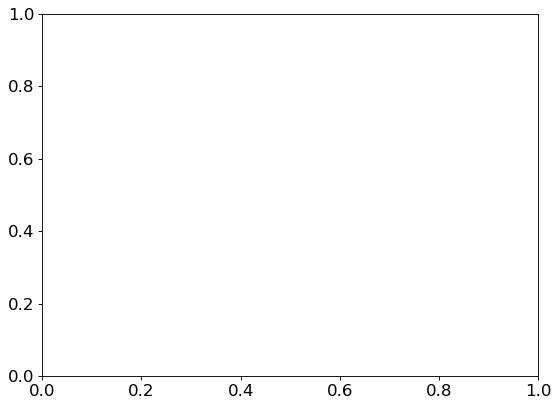

In [110]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(oob_log_loss.keys(),oob_log_loss.values(),label = 'Out of Bag Log Loss')
plt.plot(oob_log_loss.keys(),oob_log_loss.values(),'o',color = 'blue')
plt.plot(test_log_loss.keys(),test_log_loss.values(), label = 'Test Data Log Loss')
plt.xlabel('Number of Trees')
plt.ylabel('Log Loss')
plt.legend();

In [ ]:
params = {'n_estimators': [1000, 1350],
          'max_features': list(range(2,8,2)),
          'max_depth': [None,15,18],
          'max_leaf_nodes':[700,1000,1300],
          'bootstrap': [True, False]}

cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
rf_regressor_grid = GridSearchCV(RandomForestRegressor(random_state=1, n_jobs=-1), 
                                      param_grid =params, cv=cv, n_jobs=-1, verbose=1, scoring='neg_root_mean_squared_error')
rf_regressor_grid.fit(combined_train_x, combined_train_y)
print('Best Parameters : ',rf_regressor_grid.best_params_)